In [1]:
gen = "Gen1"
path = '../phd-model-process/'

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy as sp
import scipy.stats as st

from helpers_pd import *

# Plotting
import seaborn as sns
sns.set()
# import seaborn as sns; sns.set(style="ticks", color_codes=True)
# sns.set(style="darkgrid")
import matplotlib.pyplot as plt
# plt.style.use('seaborn-white')

In [2]:
palette = ["#F44336", '#673AB7', '#3F51B5', '#009688', '#FF9800', '#4CAF50', '#03A9F4']
# red, purple, indigo, teal-green, orange, green, light-blue
# https://matplotlib.org/users/dflt_style_changes.html

# Extracting observed Conc.

## Define transect

In [3]:
obs = pd.read_table(path + 'observations/conc_bulk_cal.tss')
p_b = pd.read_table(path + 'observations/p_bAve.tss')
obs.head()

,Jdays,DayMoYr,IDcal,ug.g,ug.g.SD
0,182,2016-03-30,B-182,2.864553,1.298030
1,188,2016-04-05,B-188,5.919575,2.754972
2,197,2016-04-14,B-197,4.746709,0.957630
3,201,2016-04-18,B-201,6.105674,1.029032
4,209,2016-04-26,B-209,3.838914,0.899855


# Selecting indexes

In [4]:
df = get_data(gen=gen)
counter = 0

In [5]:
# 'LHS_s2fix7/10/' in list(df.index)
# list(df)

In [43]:
df['k_d'] = df.loc[:, 'k_oc'] * df.loc[:,'f_oc']
# Combined outlet and transects KGE Concentrations and d13C
df['KGE-SM'] = (df.loc[:, 'KGE-CONC_out'] + df.loc[:, 'KGE-CONC-blk'])/2.0  
df['KGE-d13C'] = (df.loc[:, 'KGE-d13C_out'] + df.loc[:, 'KGE-d13C-blk'])/2.0

cst = 0.65
df['Constraint'] = df.apply(WithIsoKGE, args=(cst,), axis=1)

In [7]:
print("Maximum Q")
print(df['KGE-Q_out'].max(), df['NSE-Q_out'].max()) 
print("Maximum Conc.")
print(df['KGE-CONC-blk'].max(), df['KGE-CONC_out'].max(), df['KGE-SM'].max()) 
print("Maximum d13C")
print(df['KGE-d13C-blk'].max(), df['KGE-d13C_out'].max(), df['KGE-d13C'].max()) 

Maximum Q
(0.7856671938254698, 0.5624784847441313)
Maximum Conc.
(0.779633598745622, 0.36008130938978367, 0.5077238884944065)
Maximum d13C
(0.9664222569512327, 0.70432567774303, 0.8186644665934912)


In [8]:
dfs = df[['Model',
          'dt_50_ref',
          'dt_50_ab',
#           'k_d',
          'epsilon_iso',
          'KGE-CONC-blk','KGE-d13C-blk',
          'KGE-SM', 'KGE-d13C', 'Constraint'
          ]]

In [44]:
# Filter
ff = dfs.loc[(dfs['KGE-SM'] > 0.40)] # Try 25 with more data points
ff_c = dfs.loc[(dfs['KGE-SM'] > 0.1) & (dfs['KGE-d13C'] >  cst)]

# ff = dfs.loc[(dfs['KGE-CONC-blk'] > 0.70)] # Try 25 with more data points
# ff_c = dfs.loc[(dfs['KGE-CONC-blk'] > 0.0) & (dfs['KGE-d13C-blk'] >  cst)]
print(len(dfs), len(ff), len(ff_c))
ff.tail()

counter += 1

(9802, 169, 69)


### DT50

In [45]:
print(ff[['dt_50_ref']].mean())
print(ff[['dt_50_ref']].std())

dt_50_ref    14.874809
dtype: float64
dt_50_ref    4.673372
dtype: float64


In [46]:
print(ff_c[['dt_50_ref']].mean())
print(ff_c[['dt_50_ref']].std())

dt_50_ref    26.052848
dtype: float64
dt_50_ref    5.207356
dtype: float64


In [47]:
nc_fix = ff.index[(ff['Constraint'] == 'NC')& (ff["Model"]=='fix')].tolist() #[0]
nc_var = ff.index[(ff['Constraint'] == 'NC') & (ff["Model"]=='var')].tolist() #[0]

wc_fix = ff_c.index[(ff_c['Constraint'] == 'WC') & (ff_c["Model"]=='fix')].tolist() #[0]
wc_var = ff_c.index[(ff_c['Constraint'] == 'WC') & (ff_c["Model"]=='var')].tolist() #[0]
print(len(nc_fix), len(nc_var))
print(len(wc_fix), len(wc_var))

(50, 119)
(17, 11)


## Update path for Generation

In [48]:
if counter < 2:
    path += gen + '/'

# Extracting time series

In [49]:
def get_sets_bulk(name_list):
    # Get sim conc, convert mass, ug/g -> ug
    comp = ['nor', 'val', 'sou']
    sets = []
    for i in range(len(name_list)): # Set name
        transects = []
        for tran in comp:
            # Append masses and conc.
            filename = "resM_" + tran + "CONC_real.tss"
            conc_name = tran + 'CONC'
            sim = pd.read_table(path + name_list[i] + filename, 
                                skiprows=4, delim_whitespace=True,
                                names=['Jdays', conc_name],
                                header=None)
            
            mass_name = tran + "Mass"
            sim[mass_name] = sim[conc_name] * p_b['pbAve'] * 4.0 * 10.0 * 10**3
            transects.append(sim)
            
            # Append deltas
            filename = "resM_" + tran + "d13C_real.tss"
            delta_name = tran + 'd13C'
            sim = pd.read_table(path + name_list[i] + filename,
                                skiprows=4, delim_whitespace=True,
                                names=['Jdays', delta_name],
                                header=None)
            transects.append(sim)

        # Merge all transects
        blk = reduce(lambda x, y: pd.merge(x, y, on='Jdays'), transects)

        # Bulk concentration
        conc_name = 'Conc_blk' +  name_list[i][3:]
        blk[conc_name] = (blk['norCONC']*blk['norMass'] +
                          blk['valCONC']*blk['valMass'] +
                          blk['souCONC']*blk['souMass']
                          ) / (blk['norMass'] + blk['valMass'] + blk['souMass'])

        iso_name = 'd13C_blk' +  name_list[i][3:]
        blk[iso_name] = (blk['nord13C']*blk['norMass'] +
                         blk['vald13C']*blk['valMass'] +
                         blk['soud13C']*blk['souMass']
                        ) / (blk['norMass'] + blk['valMass'] + blk['souMass'])
        
        
        blk = blk[['Jdays', conc_name, iso_name]]
        sets.append(blk)
    df = reduce(lambda left, right: pd.merge(left,right,on='Jdays'), sets)
    return df

In [15]:
# sets = get_sets_bulk(wc) # Returns sets merged
# sets.tail()

# Confidence interval calc.

In [16]:
def concat(row, plot):
    return plot.capitalize() + '-' + str(int(row['Jdays']))

In [17]:
def get_stats_bulk(df, measure, cst):
    n = len(np.array(df.iloc[0,1:]))
    df['mean'] = df.iloc[:,1:n+1].mean(axis=1)
    df['min'] = df.iloc[:,1:n+1].min(axis=1)
    df['max'] = df.iloc[:,1:n+1].max(axis=1)
    df['sem'] = df.iloc[:,1:n+1].sem(axis=1)
    df['sd'] = df.iloc[:,1:n+1].std(axis=1)
    df['high'] = df['mean'] + 2.*df['sd']
    df['low'] = df['mean'] - 2.*df['sd']
#     df['high'] = df.apply(get_ci, args=(n, 0.95, True), axis=1)
#     df['low'] = df.apply(get_ci, args=(n, 0.95, False), axis=1)
    if measure == "Conc":
        df['low'] = df.apply(check_negative, axis=1)
#     df['Trans'] = loc
#     df['Area'] = loc[0]
#     df['Level'] = level  # Composite or Detailed, 
    loc = "B"
    df['IDcal'] = df.apply (lambda row: concat(row, loc), axis=1)
    df['Type'] = df.apply(lambda row: ModelType(row, cst),axis=1)
    return df[['Jdays', 'mean', 'high', 'low', 'max', 'min', 'sd', 'IDcal', 'Type']]

In [18]:
# sets_wc = get_sets_bulk(wc) 

In [50]:
nc_fix[0:3]

['LHS_be1fix3/128/', 'LHS_be1fix3/26/', 'LHS_be1fix3/30/']

In [52]:
sets_wc_fix = get_sets_bulk(wc_fix) 
sets_wc_var = get_sets_bulk(wc_var)

sets_nc_fix = get_sets_bulk(nc_fix)
sets_nc_var = get_sets_bulk(nc_var)

In [53]:
time_wc = sets_wc_fix.filter(like="Jdays")
time_nc = sets_nc_fix.filter(like="Jdays")

In [54]:
conc_wc_fix = sets_wc_fix.filter(like='Conc')
conc_wc_var = sets_wc_var.filter(like='Conc')

conc_nc_fix = sets_nc_fix.filter(like='Conc')
conc_nc_var = sets_nc_var.filter(like='Conc')

conc_wc_fix = pd.concat([time_wc, conc_wc_fix], axis=1, join='inner')
conc_wc_var = pd.concat([time_wc, conc_wc_var], axis=1, join='inner')

conc_nc_fix = pd.concat([time_nc, conc_nc_fix], axis=1, join='inner')
conc_nc_var = pd.concat([time_nc, conc_nc_var], axis=1, join='inner')

In [56]:
wc_all_fix = get_stats_bulk(conc_wc_fix, 'Conc', 'WC')
wc_all_var = get_stats_bulk(conc_wc_var, 'Conc', 'WC')

nc_all_fix = get_stats_bulk(conc_nc_fix, 'Conc', 'NC')
nc_all_var = get_stats_bulk(conc_nc_var, 'Conc', 'NC')

In [60]:
wc_merged_fix = pd.merge(wc_all_fix, obs, how='outer', on='IDcal')
wc_merged_var = pd.merge(wc_all_var, obs, how='outer', on='IDcal')

nc_merged_fix = pd.merge(nc_all_fix, obs, how='outer', on='IDcal')
nc_merged_var = pd.merge(nc_all_var, obs, how='outer', on='IDcal')

In [62]:
# wc_merged[20:25]
# wc_merged_fix.tail()

In [23]:
# nc_merged.head()
# sets_all = pd.concat([nc_merged, wc_merged])

In [24]:
# ff.tail() ff_c.tail()
# fix_nc = ff.loc[(ff['Model']=='fix')]
# var_nc = ff.loc[(ff['Model']=='var')]
# fix_wc = ff_c.loc[(ff_c['Model']=='fix')]
# var_wc = ff_c.loc[(ff_c['Model']=='var')]

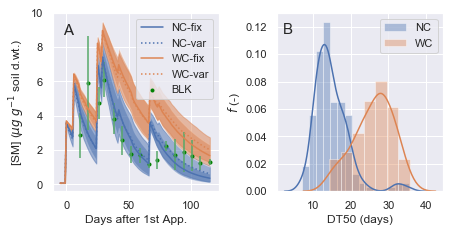

In [93]:
# sns.set(rc={'figure.figsize':(11.7, 8.27)})
# ES&T max width, 1 column = 3.25in, 2-col = 7in 
sns.set_context("paper")
sns.set(rc={'figure.figsize':(7.0, 3.3)}) # Width, height, inches

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False)

time = np.array(nc_merged_fix['Jdays_x']-171)
obs_conc = np.array(nc_merged_fix['ug.g'])
err = np.array(nc_merged_fix['ug.g.SD'])

nc_mean_fix = np.array(nc_merged_fix['mean'])
nc_high_fix = np.array(nc_merged_fix['high'])
nc_low_fix = np.array(nc_merged_fix['low'])

nc_mean_var = np.array(nc_merged_var['mean'])
nc_high_var = np.array(nc_merged_var['high'])
nc_low_var = np.array(nc_merged_var['low'])

wc_mean_fix = np.array(wc_merged_fix['mean'])
wc_high_fix = np.array(wc_merged_fix['high'])
wc_low_fix = np.array(wc_merged_fix['low'])

wc_mean_var = np.array(wc_merged_var['mean'])
wc_high_var = np.array(wc_merged_var['high'])
wc_low_var = np.array(wc_merged_var['low'])

# ax1.annotate('A', fontsize=15,
#             xy=(50, 225), xycoords='figure pixels')
# ax2.annotate('B', fontsize=15,
#             xy=(275, 225), xycoords='figure pixels')
ax1.annotate('A', fontsize=15,
            xy=(-3, 8.7), xycoords='data')
ax2.annotate('B', fontsize=15,
            xy=(2, 0.115), xycoords='data')


# NC
ax1.plot(time, nc_mean_fix, label='NC-fix') # c= "red", marker='.', linestyle=':'
ax1.legend(loc="upper right")
ax1.fill_between(time, nc_high_fix, nc_low_fix, alpha=0.5)

ax1.plot(time, nc_mean_var, label='NC-var', color="C0", linestyle=':') # c= "red", marker='.'
ax1.legend(loc="upper right")
ax1.fill_between(time, nc_high_var, nc_low_var, color="C0", alpha=0.5)

# WC
ax1.plot(time, wc_mean_fix, label='WC-fix') # c= "red", marker='.', linestyle=':'
ax1.legend(loc="upper right")
ax1.fill_between(time, wc_high_fix, wc_low_fix, alpha=0.5)

ax1.plot(time, wc_mean_var, label='WC-var', color="C1", linestyle=':') # c= "red", marker='.', linestyle=':'
ax1.legend(loc="upper right")
ax1.fill_between(time, wc_high_var, wc_low_var, color="C1", alpha=0.5)

# Obs
ax1.errorbar(time, obs_conc, err)
ax1.scatter(time, obs_conc, c= "green", marker='.', label="BLK")
ax1.legend(loc="upper right")
ax1.set_ylabel("[SM] ($\mu g$ $g^{-1}$ soil d.wt.)")
ax1.set_xlabel("Days after 1st App.")

sns.distplot( ff["dt_50_ref"] , color="C0", label="NC", ax=ax2)
# sns.distplot( var_nc["dt_50_ref"] , color="red", label="Var - NC", ax=ax2)
sns.distplot( ff_c["dt_50_ref"] , color="C1", label="WC", ax=ax2)
# sns.distplot( var_wc["dt_50_ref"] , color="teal", label="Var - WC", ax=ax2)
ax2.set_xlabel("DT50 (days)")
ax2.set_ylabel("$f$ (-)")

plt.subplots_adjust(left=None, bottom=.2, right=None, top=.95,
                wspace=0.35, hspace=None)
plt.legend()

fig.savefig("Fig1_FitNC.pdf")
# sns.pointplot(x="Jdays_x", y="ug.g", data=sets_all.loc[sets_all['Type']=="WC"], join=False, ax=ax1)

In [24]:
200-171

29

https://python-graph-gallery.com/25-histogram-with-several-variables-seaborn/

In [97]:
3750-(2408+1850)

-508